In [1]:
import jax
from jax import numpy as jnp, random, nn, jit, vmap

import haiku as hk

import optax

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial

import sklearn as sk
from sklearn import datasets, metrics, model_selection

In [2]:
rng = hk.PRNGSequence(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


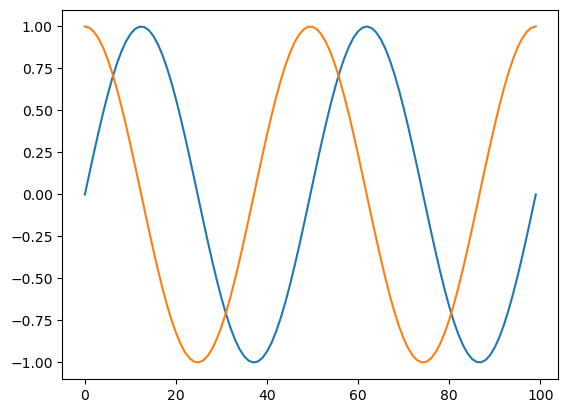

In [191]:
t = jnp.linspace(-2*np.pi,2*np.pi,100)
x = jnp.stack([
    jnp.sin(t),
    jnp.cos(t)
], axis=-1)

plt.plot(x)

# Bistable feedback

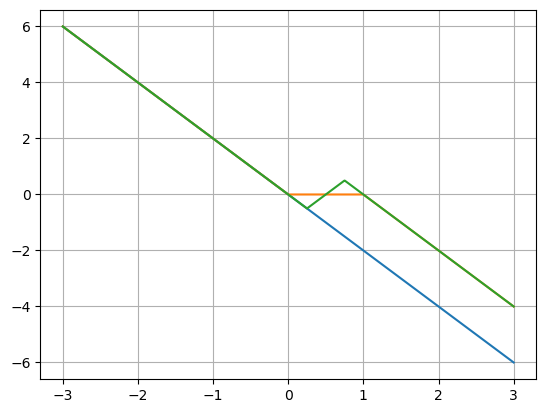

In [427]:
def step(x):
    return jnp.clip(x, -1, 1)

def f(x,a):
    z = 2*x-jnp.minimum(1,a)
    return step(a*z)-z
x = jnp.linspace(-3,3,1024)
for a in [0.0,1.0,2.0]:
    plt.plot(x, f(x,a=a))
plt.grid()

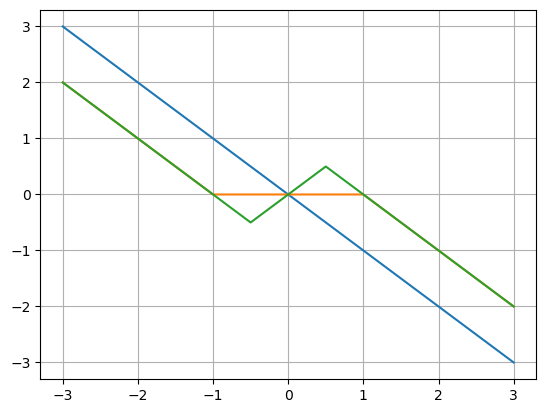

In [206]:
x = jnp.linspace(-3,3,1024)
def f(x,a):
    return jnp.clip(a*x,-1,1) - x
for a in [0.0, 1.0, 2.0]:
    plt.plot(x,f(x,a))
plt.grid()

# Kernel Quantizer

In [232]:
class Quantizer(hk.Module):
    def __init__(self, n_kernels, init_position=None, init_log_width=None, name=None):
        super().__init__(name=name)
        self.n_kernels = n_kernels
        self.init_position = init_position or \
            hk.initializers.RandomUniform(-1,1)
        self.init_log_width = init_log_width or \
            hk.initializers.Constant(np.log(2/n_kernels)*0.5)
        self.n_feature = None
    
    @property 
    
    def encode(self, data): # [#time, #feature]
        if self.n_feature is None:
            self.n_feature = data.shape[1]
        n_time = data.shape[0]
        n_feature = self.n_feature
        n_kernels = self.n_kernels
        position = hk.get_parameter('position', shape = [n_feature, n_kernels],
                                    init = self.init_position)
        width = jnp.exp(hk.get_parameter('log_width', shape = [n_feature, n_kernels],
                                         init = self.init_log_width))
        @partial(vmap, in_axes = [0, None, None])
        def kernel(x,p,w): # x = [#time,#feature,1]
            z = x-p
            y = jnp.exp(-(z/w)**2)/(w*jnp.sqrt(2.0*np.pi))
            return jnp.ravel(y)
        return kernel(jnp.expand_dims(data, axis=-1), position, width)        
    
    def decode(self, data): # [#time, #kernel]
        n_time = data.shape[0]
        n_feature = self.n_feature
        n_kernels = self.n_kernels
        

In [34]:
qt = Quantizer(32)

In [35]:
@hk.without_apply_rng
@hk.transform
def forward(x):
    return qt.encode(x)

In [39]:
def gen(k):
    n_time = 128
    t = jnp.linspace(-2*np.pi, 2*np.pi, n_time)
    return jnp.sin(k*t)

In [46]:
data = vmap(gen)(random.normal(next(rng), [1024]))
data = jnp.expand_dims(data, axis=-1)
data.shape

(1024, 128, 1)

In [65]:
params = forward.init(next(rng), data[0])

y = vmap(forward.apply, in_axes=[None, 0])(params, data)
y.shape

(1024, 128, 32)

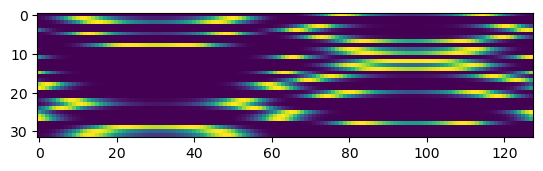

In [66]:
plt.imshow(y[0,:].T)

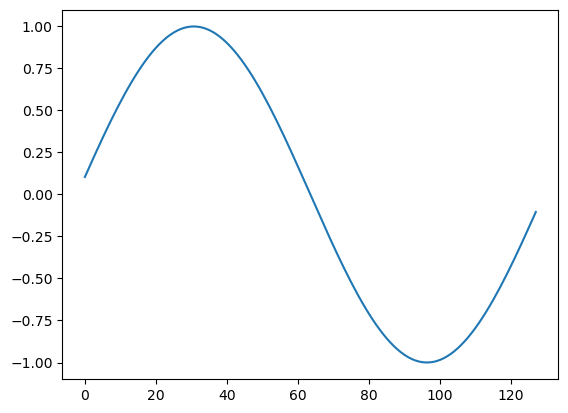

In [63]:
plt.plot(data[0,:])

In [226]:
@hk.without_apply_rng
@hk.multi_transform
def model():
    encode = hk.Linear(32, name='encode')
    decode = hk.Linear(1, name='decode')
    def forward(x):
        z = encode(x)
        return decode(z)
    return forward, (encode, decode, forward)

In [227]:
x = jnp.zeros(shape = [32,3])
params = model.init(next(rng), x)

In [228]:
encode, decode, forward = model.apply

In [229]:
encode(params, x).shape

(32, 32)

In [230]:
forward(params, x).shape

(32, 1)

In [231]:
decode(params, encode(params, x)).shape

(32, 1)

In [207]:
?hk.multi_transform

Signature: hk.multi_transform(f: Callable[[], Tuple[Callable[..., Any], Any]]) -> haiku._src.multi_transform.MultiTransformed
Docstring:
Transforms a collection of functions using Haiku into pure functions.

In many scenarios we have several modules which are used either as primitives
for several Haiku modules/functions, or whose pure versions are to be reused
in downstream code. This utility enables this by applying
:func:`transform` to an arbitrary tree of Haiku functions which share modules
and have a common ``init`` function.

``f`` is expected to return a tuple of two elements. First is a ``template``
Haiku function which provides an example of how all internal Haiku modules are
connected. This function is used to create a common ``init`` function (with
your parameters).

The second object is an arbitrary tree of Haiku functions all of which reuse
the modules connected in the ``template`` function. These functions are
transformed to pure ``apply`` functions.

Example:

>>> def f()

In [190]:
x = random.normal(next(rng), shape = [60*24*240,128])
x.shape

(345600, 128)

In [175]:
qt = Quantizer(32)

def forward(x):
    return qt.encode(x)

In [109]:
params = forward.init(next(rng), x)

In [191]:
def f(x):
    return hk.VanillaRNN(x.shape[-1])(x,x)

In [192]:
print(hk.experimental.tabulate(f)(x))

+-------------------------------+-----------------------------+-----------------+----------------------------------+------------------------------------+---------------+---------------+
| Module                        | Config                      | Module params   | Input                            | Output                             |   Param count |   Param bytes |
+===============================+=============================+=================+==================================+====================================+===============+===============+
| vanilla_rnn (VanillaRNN)      | VanillaRNN(hidden_size=128) |                 | f32[345600,128], f32[345600,128] | (f32[345600,128], f32[345600,128]) |        33,024 |     132.10 KB |
+-------------------------------+-----------------------------+-----------------+----------------------------------+------------------------------------+---------------+---------------+
| vanilla_rnn/linear (Linear)   | Linear(output_size=128)     | w: f32

In [198]:
a,b,c = hk.transform(lambda x: hk.Linear(32)(x))

ValueError: not enough values to unpack (expected 3, got 2)

(100, 2, 1)

In [826]:
image, label = datasets.fetch_openml('mnist_784', return_X_y=True, as_frame=False)

image = jax.device_put(image.astype(jnp.float32))
label = jax.device_put(label.astype(jnp.float32))
type(image), type(label), image.shape, label.shape

/home/docker/mambaforge/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(jaxlib.xla_extension.ArrayImpl,
 jaxlib.xla_extension.ArrayImpl,
 (70000, 784),
 (70000,))

In [793]:
@hk.without_apply_rng
@hk.transform
def model(x):
    din,dout = x.shape[-1], 10
    w = hk.get_parameter('weight', shape=[din,dout], 
                         init=hk.initializers.TruncatedNormal(1/np.sqrt(din)))
    b = hk.get_parameter('bias', shape=[dout], init = jnp.zeros)
    return x @ w + b

In [37]:
trainX,testX, trainY,testY = model_selection.train_test_split(image, label)

In [806]:
@jit
@partial(vmap, in_axes = [None,0])
def forward(params, x):
    return model.apply(params, x)

def loss(params, x,y):
    target = nn.one_hot(y,10)
    z = nn.log_softmax(forward(params, x))
    return -jnp.mean(z * target)

def score(params, x,y):
    pred = jnp.argmax(forward(params, x), axis=-1)
    return metrics.f1_score(y, pred, average='macro')

# Sampler as an optimizer

In [807]:
from typing import NamedTuple

class SamplerState(NamedTuple):
    count: int

def sampler(scheduler):
    def init(params):
        return SamplerState(0)
    def update(updates, state, params):
        def tristable_feedback(p):
            return - p*(1-p**2)*(1-4*p**2)
        
        lr = scheduler(state.count)
        updates = jax.tree_map(
            lambda u,p: u + lr * tristable_feedback(p),
            updates,
            params
        )
        return updates, SamplerState(state.count + 1)
    return optax.GradientTransformation(init, update)

In [808]:
def tree_map(map_fn, tree):
    def rec(v,k=None):
        if isinstance(v, dict):
            return { k: rec(v,k) for k,v in v.items() }
        else:
            return map_fn(v,k)
    return rec(tree)

In [809]:
params = model.init(next(rng), trainX)
n_params = jax.tree_util.tree_reduce(lambda c,x: c + np.prod(x.shape), params, 0)
step_size = 1/n_params**.5
opt = optax.multi_transform({
    'weight': optax.chain(
        optax.scale_by_schedule(lambda i: -step_size/jnp.maximum(1,i-100)**.5),
        sampler(lambda i: 1-nn.sigmoid(jnp.float32(i-100)))
    ),
    'bias': optax.adam(step_size)
}, tree_map(lambda _, key: key, params))
opt_state = opt.init(params)

In [810]:
@jit
def update(params, opt_state, x,y):
    l,dw = jax.value_and_grad(loss)(params, x,y)
    dw, opt_state = opt.update(dw, opt_state, params)
    params = optax.apply_updates(params, dw)
    return l, params, opt_state    

In [811]:
scores = []
for _ in tqdm(range(300)):
    scores.append([
        score(params, trainX,trainY),
        score(params, testX, testY)
    ])
    _, params, opt_state = update(params,opt_state, trainX,trainY)
scores[-1]

100% 300/300 [01:04<00:00,  4.67it/s]


[0.9052565596439889, 0.9003585430341401]

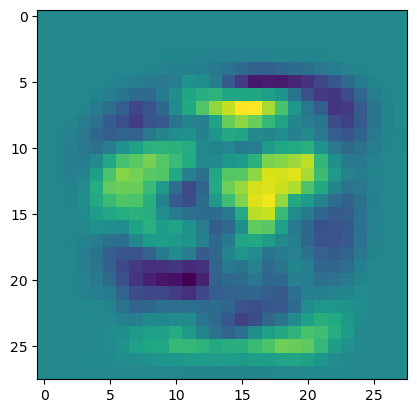

In [822]:
plt.imshow(params['~']['weight'][:,9].reshape(28,28))

(array([   8.,   25.,   88.,  183.,  688., 4968., 1132.,  541.,  170.,
          37.]),
 array([-0.02922818, -0.02418063, -0.01913308, -0.01408554, -0.00903799,
        -0.00399044,  0.0010571 ,  0.00610465,  0.0111522 ,  0.01619974,
         0.02124729]),
 <BarContainer object of 10 artists>)

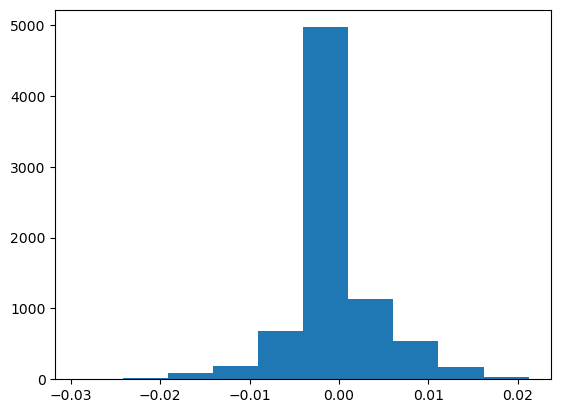

In [823]:
plt.hist(params['~']['weight'].reshape(-1))

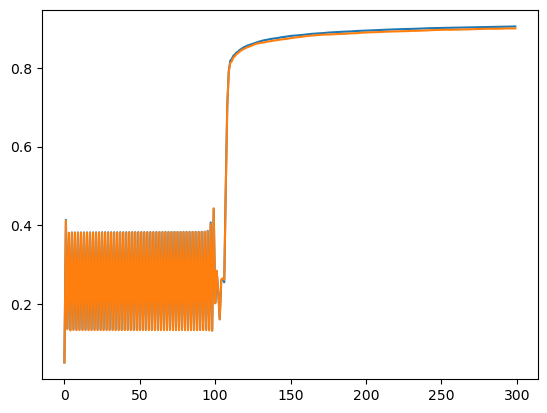

In [824]:
plt.plot(scores[-1000:])

In [1]:
import datetime as dt
import io

# from imurl import URL
import json

# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import requests as rq
import sympy as sp

ModuleNotFoundError: No module named 'pandas'

In [12]:
from sympy import *

In [13]:
from sympy.abc import N

In [19]:
A = MatrixSymbol('A', N,N)

In [2]:
class E(Function):
    @classmethod
    def eval(cls, arg):
        if isinstance(arg, Number):
            return arg
        else:
            return None

    def expand(self):
        arg = self.args[0].expand()
        cls = self.__class__
        
        def isconst(expr):
            if isinstance(expr, Number):
                return True
            elif isinstance(expr, cls):
                return True
            elif isinstance(expr, Pow) and isinstance(expr.args[0], cls):
                return True
            return False
        
        if isinstance(arg, Symbol):
            return self
        if isconst(arg):
            return arg
        elif isinstance(arg, Add):
            return Add(*[cls(x) for x in arg.args])
        elif isinstance(arg, Mul):
            const = Mul(*[x for x in arg.args if isconst(x)])
            var = Mul(*[x for x in arg.args if not isconst(x)])
            return Mul(const, cls(var))
        else:
            return cls(arg)
        
    def diff(self, *args):
        return self.__class__(self.args[0].diff(*args))

In [3]:
class Ew(Function):
    @classmethod
    def eval(cls, arg):
        if isinstance(arg, Number):
            return arg
        else:
            return None

    def expand(self):
        arg = self.args[0].expand()
        cls = self.__class__
        
        def isconst(expr):
            if isinstance(expr, Number):
                return True
            elif isinstance(expr, cls):
                return True
            elif isinstance(expr, Pow) and isinstance(expr.args[0], cls):
                return True
            return False
        
        if isinstance(arg, Symbol):
            return self
        if isconst(arg):
            return arg
        elif isinstance(arg, Add):
            return Add(*[cls(x) for x in arg.args])
        elif isinstance(arg, Mul):
            const = Mul(*[x for x in arg.args if isconst(x)])
            var = Mul(*[x for x in arg.args if not isconst(x)])
            return Mul(const, cls(var))
        else:
            return cls(arg)
        
    def diff(self, *args):
        return self.__class__(self.args[0].diff(*args))

In [4]:
pa,pb,a,b = symbols('p_x,p_-x,a,b')
F = E(-log(Ew(pa**a * pb**b)))
F

E(-log(Ew(p_-x**b*p_x**a)))

In [7]:
CV = F.subs(b,0)
CV

E(-log(Ew(p_x**a)))

In [9]:
CV.diff(a).subs(a,0)

E(-Ew(log(p_x)))

In [10]:
CV.diff(a,2).subs(a,0)

E(Ew(log(p_x))**2 - Ew(log(p_x)**2))

In [11]:
CV.diff(a,3).subs(a,0)

E(-2*Ew(log(p_x))**3 + 3*Ew(log(p_x))*Ew(log(p_x)**2) - Ew(log(p_x)**3))

In [21]:
f = log(a+x/a)
f

log(a + x/a)

In [30]:
f.diff(x,1).subs(x,0)

a**(-2)

In [31]:
f.diff(x,2).subs(x,0)

-1/a**4

In [32]:
f.diff(x,3).subs(x,0)

2/a**6

In [33]:
f.diff(x,4).subs(x,0)

-6/a**8

In [46]:
a,b,e,v = symbols('a,b,e,v')
a = (e*(1-e)-v)/v*e
b = (e*(1-e)-v)/v*(1-e)
(a/(a+b)).simplify()

e

In [48]:
((a-1)/(a+b-1)).simplify()

(e**3 - e**2 + e*v + v)/(e**2 - e + 2*v)

In [53]:
solve(((a-1)/(a+b-1)) - 1)

[{e: 1}, {e: 1/2 - sqrt(1 - 4*v)/2}, {e: sqrt(1 - 4*v)/2 + 1/2}]

In [51]:
solve

<function sympy.solvers.solvers.solve(f, *symbols, **flags)>

In [50]:
(e**3-e**2+e*v+v - (e**2 - e + 2*v)).

AttributeError: 'Add' object has no attribute 'solve'

In [36]:
p = symbols('p')
H = 1/E(1/p)
H

1/E(1/p)

In [44]:
(H/p).diff(p,1)

-E(-1/p**2)/(p*E(1/p)**2) - 1/(p**2*E(1/p))

In [13]:
W = F.subs(b,0)
W

E(-log(Ew(p_x**a)))

In [14]:
W.diff(a,2).subs(a,1)

E(-(Ew(p_x*log(p_x)**2) - Ew(p_x*log(p_x))**2/Ew(p_x))/Ew(p_x))

In [894]:
M = F.subs([(a,a-1), (b,0)])
M

 ⎛    ⎛  ⎛  a - 1⎞⎞⎞
E⎝-log⎝Ew⎝pₓ     ⎠⎠⎠

In [898]:
F.diff(a,2).subs(a,0).subs(b,1).expand()

 ⎛  2             ⎞    ⎛   ⎛       2    ⎞ ⎞
 ⎜Ew (p₋ₓ⋅log(pₓ))⎟    ⎜-Ew⎝p₋ₓ⋅log (pₓ)⎠ ⎟
E⎜────────────────⎟ + E⎜──────────────────⎟
 ⎜      2         ⎟    ⎝     Ew(p₋ₓ)      ⎠
 ⎝    Ew (p₋ₓ)    ⎠                        

In [895]:
M.diff(a,1).subs(a,1)

E(-Ew(log(pₓ)))

In [896]:
M.diff(a,2).subs(a,1)

 ⎛  2              ⎛   2    ⎞⎞
E⎝Ew (log(pₓ)) - Ew⎝log (pₓ)⎠⎠

 ⎛ ⎛                                                             2⎛   a   a   
 ⎜ ⎜  ⎛   a   a ⎛   2                                2    ⎞⎞   Ew ⎝p₋ₓ ⋅pₓ ⋅(l
 ⎜-⎜Ew⎝p₋ₓ ⋅pₓ ⋅⎝log (p₋ₓ) + 2⋅log(p₋ₓ)⋅log(pₓ) + log (pₓ)⎠⎠ - ───────────────
 ⎜ ⎜                                                                        ⎛ 
 ⎜ ⎝                                                                      Ew⎝p
E⎜────────────────────────────────────────────────────────────────────────────
 ⎜                                             ⎛   a   a⎞                     
 ⎝                                           Ew⎝p₋ₓ ⋅pₓ ⎠                     

                  ⎞⎞ ⎞
og(p₋ₓ) + log(pₓ))⎠⎟ ⎟
───────────────────⎟ ⎟
  a   a⎞           ⎟ ⎟
₋ₓ ⋅pₓ ⎠           ⎠ ⎟
─────────────────────⎟
                     ⎟
                     ⎠

In [877]:
F.subs([(a,1),(b,1)]) - F.subs([(a,0),(b,1)])

-E(-log(Ew(pₓ))) + E(-log(Ew(pₓ⋅p_x̃)))

In [878]:
F.diff(a,1).subs([(a,0), (b,1)])

 ⎛-Ew(pₓ⋅log(p_x̃)) ⎞
E⎜─────────────────⎟
 ⎝      Ew(pₓ)     ⎠

In [880]:
F.diff(a,2).subs([(a,0), (b,1)]).expand()

 ⎛  2             ⎞    ⎛   ⎛      2     ⎞ ⎞
 ⎜Ew (pₓ⋅log(p_x̃))⎟    ⎜-Ew⎝pₓ⋅log (p_x̃)⎠ ⎟
E⎜────────────────⎟ + E⎜──────────────────⎟
 ⎜      2         ⎟    ⎝      Ew(pₓ)      ⎠
 ⎝    Ew (pₓ)     ⎠                        

In [852]:
(Fa4+v2Kurt.expand())

   4         2     ⎛ 2⎞      2⎛ 2⎞
3⋅E (l) - 6⋅E (l)⋅E⎝l ⎠ + 3⋅E ⎝l ⎠

In [854]:
E((l**2-E(l**2))**2).expand()

   2⎛ 2⎞    ⎛ 4⎞
- E ⎝l ⎠ + E⎝l ⎠

In [862]:
x,m,v = symbols('x,m,v')

In [864]:
f = exp(-(x-m)**2/v)

In [867]:
f.diff(m,2)

                             2 
                     -(m - x)  
  ⎛              2⎞  ──────────
  ⎜     2⋅(m - x) ⎟      v     
2⋅⎜-1 + ──────────⎟⋅ℯ          
  ⎝         v     ⎠            
───────────────────────────────
               v               

In [ ]:
2(m - x)^2/v - 1 < 0 and (m - x)^2/v - 2 < 0
=> (m-x)^2/v < 1/2


In [868]:
f.diff(v,2)

                                  2 
                          -(m - x)  
⎛            2⎞           ──────────
⎜     (m - x) ⎟        2      v     
⎜-2 + ────────⎟⋅(m - x) ⋅ℯ          
⎝        v    ⎠                     
────────────────────────────────────
                  3                 
                 v                  

In [871]:
g = symbols('g')
f = exp(E(log(g)))
f

 E(log(g))
ℯ         

In [872]:
f.diff(g)

 E(log(g))  ⎛1⎞
ℯ         ⋅E⎜─⎟
            ⎝g⎠

In [873]:
f.diff(g,2)

⎛ ⎛-1 ⎞    2⎛1⎞⎞  E(log(g))
⎜E⎜───⎟ + E ⎜─⎟⎟⋅ℯ         
⎜ ⎜  2⎟     ⎝g⎠⎟           
⎝ ⎝ g ⎠        ⎠           

In [2]:
from sympy import *

In [6]:
t = symbols('t')
S = Function('S')(t)

In [40]:
class S(Function):
    def fdiff(self, argindex=1):
        return S(self.args[0]) * (1 - S(self.args[0]))

In [54]:
Derivative(S(t), (t,10)).doit().expand()

3628800*S(t)**11 - 19958400*S(t)**10 + 46569600*S(t)**9 - 59875200*S(t)**8 + 46070640*S(t)**7 - 21538440*S(t)**6 + 5921520*S(t)**5 - 874500*S(t)**4 + 57002*S(t)**3 - 1023*S(t)**2 + S(t)

In [33]:
x,a = symbols('x,a')

In [34]:
D = Derivative

In [36]:
f = 1-(1-x)**(1/a)

In [49]:
def taylor(f, x, x0=0, n=3):
    return sum(D(f, (x,i)).subs(x,x0) * (x-x0)**i/factorial(i) for i in range(n))

In [65]:
taylor((1-x)**(1/a), x, x0=0, n=4).doit().collect(x)

1 - x**3*(2 - 3/a + a**(-2))/(6*a) + x**2*(-1 + 1/a)/(2*a) - x/a

In [7]:
functions

<module 'sympy.functions' from '/home/docker/mambaforge/lib/python3.10/site-packages/sympy/functions/__init__.py'>

TypeError: 'Symbol' object is not callable

In [185]:
S,I,R,A,β,γ,μ,η,J = symbols('S,I,R,A,β,γ,μ,η,J', positive=True)

In [186]:
sys = Array([
    Eq(R, γ/β * β*J/(μ+η*β*J)),
    Eq(S, γ/β * μ/(μ+η*β*J)),
    Eq(A, β*J**2/(μ+η*β*J)),
    Eq(I, μ*J/(μ+η*β*J)),
    Eq(S+I+R+A,1)
])
sys

[Eq(R, J*γ/(J*β*η + μ)), Eq(S, γ*μ/(β*(J*β*η + μ))), Eq(A, J**2*β/(J*β*η + μ)), Eq(I, J*μ/(J*β*η + μ)), Eq(A + I + R + S, 1)]

In [187]:
Eq(1, sum(f.rhs for f in sys[:4]))

Eq(1, J**2*β/(J*β*η + μ) + J*γ/(J*β*η + μ) + J*μ/(J*β*η + μ) + γ*μ/(β*(J*β*η + μ)))

In [188]:
sol = Array(solve(Eq(1, sum(f.rhs for f in sys[:4])), J))
sol

[(β*η - γ - μ - sqrt(β**2*η**2 - 2*β*γ*η - 2*β*η*μ + 4*β*μ + γ**2 - 2*γ*μ + μ**2))/(2*β), (β*η - γ - μ + sqrt(β**2*η**2 - 2*β*γ*η - 2*β*η*μ + 4*β*μ + γ**2 - 2*γ*μ + μ**2))/(2*β)]

In [189]:
str(sol[1])

'(β*η - γ - μ + sqrt(β**2*η**2 - 2*β*γ*η - 2*β*η*μ + 4*β*μ + γ**2 - 2*γ*μ + μ**2))/(2*β)'

In [190]:
eq = (β**2*η**2 - 2*β*γ*η - 2*β*η*μ + 4*β*μ + γ**2 - 2*γ*μ + μ**2) - (β*η-γ-μ)**2
eq.simplify()

4*μ*(β - γ)

In [191]:
Jinf = (β*η - γ - μ + sqrt((β*η-γ-μ)**2 + 4*μ*(β-γ)))/(2*β)
Jinf

(β*η - γ - μ + sqrt(4*μ*(β - γ) + (β*η - γ - μ)**2))/(2*β)

In [193]:
Iη0 = sys[3].subs([(J, Jinf), (η,0)])
Iη0

Eq(I, (-γ - μ + sqrt(4*μ*(β - γ) + (-γ - μ)**2))/(2*β))

In [195]:
solβ_η0 = Array(solve(Derivative(sys[3].rhs.subs([(J,Jinf), (η,0)]), β).doit(), β))
solβ_η0

[(-sqrt(γ)*(γ + μ) + 2*γ*sqrt(μ))/sqrt(μ), (sqrt(γ)*(γ + μ) + 2*γ*sqrt(μ))/sqrt(μ)]

In [201]:
(solβ_η0[1]/γ).simplify()

sqrt(γ)/sqrt(μ) + 2 + sqrt(μ)/sqrt(γ)

In [198]:
sys[3].rhs.subs(J,Jinf).limit(η,oo)

0

In [95]:
sys2.subs(a,b).subs(d,g)

[Eq(A, μ*(S - 1)*(S*β - γ)/(S*β*γ*η + S*β*η*μ - S*β*μ + γ*μ)), Eq(I, -S*β*η*μ*(S - 1)/(S*β*γ*η + S*β*η*μ - S*β*μ + γ*μ)), Eq(J, -γ*η*μ*(S - 1)/(S*β*γ*η + S*β*η*μ - S*β*μ + γ*μ)), Eq(R, -S*β*γ*η*(S - 1)/(S*β*γ*η + S*β*η*μ - S*β*μ + γ*μ))]

In [69]:
sol = solve([ sys[0], sys[1], sys[2], sys[3] ])[0]
sys2 = Array([ Eq(k,v) for k,v in sol.items()])
sys2

[Eq(A, δ*μ*(S*β - γ)**2/(S*α*β*γ**2*η**2)), Eq(I, -δ*μ*(S*β - γ)/(α*γ**2*η)), Eq(J, -δ*μ*(S*β - γ)/(S*α*β*γ*η)), Eq(R, -δ*(S*β - γ)/(α*γ*η))]

In [85]:
solve(Eq(S, 1-sol[I]-sol[R]-sol[A]), S)

[S*β*δ/(α*γ*η) + S*β*δ*μ/(α*γ**2*η) + 1 - δ/(α*η) - δ*μ/(α*γ*η) - δ*μ*(S*β - γ)**2/(S*α*β*γ**2*η**2)]

In [311]:
S,I,A,R,b,g,m,e,eps,J = symbols('S,I,A,R,β,γ,μ,η,ϵ,J', positive=True)

sys = Array([
    Eq(0, m*R - b*S*J),
    Eq(0, b*S*J - g*I),
    Eq(0, eps*b*R*J - g*A),
    Eq(0, g*I-m*R + g*A-eps*b*R*J)
])
sys

[Eq(0, -J*S*β + R*μ), Eq(0, -I*γ + J*S*β), Eq(0, -A*γ + J*R*β*ϵ), Eq(0, A*γ + I*γ - J*R*β*ϵ - R*μ)]

In [335]:
i0,i1,i2 = symbols('i0,i1,i2')

sys2 = sys.subs(J, I+e*A).subs(I, i0 + i1*eps + i2*eps**2)
sys2

[Eq(0, R*μ - S*β*(A*η + i0 + i1*ϵ + i2*ϵ**2)), Eq(0, S*β*(A*η + i0 + i1*ϵ + i2*ϵ**2) - γ*(i0 + i1*ϵ + i2*ϵ**2)), Eq(0, -A*γ + R*β*ϵ*(A*η + i0 + i1*ϵ + i2*ϵ**2)), Eq(0, A*γ - R*β*ϵ*(A*η + i0 + i1*ϵ + i2*ϵ**2) - R*μ + γ*(i0 + i1*ϵ + i2*ϵ**2))]

In [101]:
S,I,R,A,b,g,m,e,J = symbols('S,I,R,A,β,γ,m,η,J', positive=True)

In [109]:
sol = solve([
    Eq(S+I+R+A, 1),
    Eq(m*R, b*S*J),
    Eq(b*S*J, g*I),
    Eq(b*R*J, g*A),
    Eq(m*R+b*R*J, g*I+g*A),
    # Eq(J, I+e*A)
], [S,I,R,A])

In [110]:
sols = Array([ [Eq(f, sol[f])] for f in [S,I,R,A] ])
sols

[[Eq(S, m*γ/(J**2*β**2 + J*m*β + J*β*γ + m*γ))], [Eq(I, J*m*β/(J**2*β**2 + J*m*β + J*β*γ + m*γ))], [Eq(R, J*β*γ/(J**2*β**2 + J*m*β + J*β*γ + m*γ))], [Eq(A, J**2*β**2/(J**2*β**2 + J*m*β + J*β*γ + m*γ))]]

In [111]:
sqrt(1/5/100)

0.0447213595499958

In [147]:
K = Function('K')(b)
newsols = sols.subs(fraction(sols[0][0].rhs)[1], K)
newsols

[[Eq(S, m*γ/K(β))], [Eq(I, J*m*β/K(β))], [Eq(R, J*β*γ/K(β))], [Eq(A, J**2*β**2/K(β))]]

In [153]:
Dnewsols = Array([
    [ Eq(Derivative(Function(f.lhs)(b), b), Derivative(f.rhs, b).doit()) ]
    for [f] in newsols
])
Dnewsols

[[Eq(Derivative(S(β), β), -m*γ*Derivative(K(β), β)/K(β)**2)], [Eq(Derivative(I(β), β), -J*m*β*Derivative(K(β), β)/K(β)**2 + J*m/K(β))], [Eq(Derivative(R(β), β), -J*β*γ*Derivative(K(β), β)/K(β)**2 + J*γ/K(β))], [Eq(Derivative(A(β), β), -J**2*β**2*Derivative(K(β), β)/K(β)**2 + 2*J**2*β/K(β))]]

In [155]:
Dnewsols.subs(K, fraction(sols[0][0].rhs)[1]).doit()

[[Eq(Derivative(S(β), β), -m*γ*(2*J**2*β + J*m + J*γ)/(J**2*β**2 + J*m*β + J*β*γ + m*γ)**2)], [Eq(Derivative(I(β), β), -J*m*β*(2*J**2*β + J*m + J*γ)/(J**2*β**2 + J*m*β + J*β*γ + m*γ)**2 + J*m/(J**2*β**2 + J*m*β + J*β*γ + m*γ))], [Eq(Derivative(R(β), β), -J*β*γ*(2*J**2*β + J*m + J*γ)/(J**2*β**2 + J*m*β + J*β*γ + m*γ)**2 + J*γ/(J**2*β**2 + J*m*β + J*β*γ + m*γ))], [Eq(Derivative(A(β), β), -J**2*β**2*(2*J**2*β + J*m + J*γ)/(J**2*β**2 + J*m*β + J*β*γ + m*γ)**2 + 2*J**2*β/(J**2*β**2 + J*m*β + J*β*γ + m*γ))]]

In [177]:
[eqS], [eqI], *_ = sols
eqS

Eq(S, m*γ/(J**2*β**2 + J*m*β + J*β*γ + m*γ))

In [178]:
eqI

Eq(I, J*m*β/(J**2*β**2 + J*m*β + J*β*γ + m*γ))

In [180]:
I_new = b*eqS.rhs*eqI.rhs
I_new

J*m**2*β**2*γ/(J**2*β**2 + J*m*β + J*β*γ + m*γ)**2

In [182]:
solve(Eq(0, Derivative(I_new, b)).doit(), b)[0]

sqrt(m)*sqrt(γ)/J

In [136]:
Eq(
    Derivative(sols[1]
    Derivative(sols[1][0].rhs, b).doit()
)

J*m*β*(-2*J**2*β - J*m - J*γ)/(J**2*β**2 + J*m*β + J*β*γ + m*γ)**2 + J*m/(J**2*β**2 + J*m*β + J*β*γ + m*γ)

In [127]:
R0 = symbols('R0', positive=True)
sols\
    .subs(b, R0*g)

[[Eq(S, m*γ/(J**2*R0**2*γ**2 + J*R0*m*γ + J*R0*γ**2 + m*γ))], [Eq(I, J*R0*m*γ/(J**2*R0**2*γ**2 + J*R0*m*γ + J*R0*γ**2 + m*γ))], [Eq(R, J*R0*γ**2/(J**2*R0**2*γ**2 + J*R0*m*γ + J*R0*γ**2 + m*γ))], [Eq(A, J**2*R0**2*γ**2/(J**2*R0**2*γ**2 + J*R0*m*γ + J*R0*γ**2 + m*γ))]]

In [93]:
K = symbols('K', positive=True)

In [94]:
Array([[Eq(f, solve(Eq(f, fraction(sol[f])[0]/K).subs(J, I+e*A), f)[0])] for f in [S,I,R,A]])

[[Eq(S, m*γ/K)], [Eq(I, A*m*β*η/(K - m*β))], [Eq(R, β*γ*(A*η + I)/K)], [Eq(A, (-2*I*β**2*η - sqrt(K)*sqrt(-4*I*β**2*η + K) + K)/(2*β**2*η**2))]]

In [ ]:
def bisect_left(arr, x):
    l,r = 0, len(arr)
    while r > l:
        m = (l + r) >> 1
        if x <= arr[m]:
            r = m
        else:
            l = m + 1
    return l

In [ ]:
[(i, bisect_left(x, i)) for i in range(10)]

In [ ]:
def bisect_right(arr, x):
    l, r = 0, len(arr)
    while r > l:
        m = (l + r) >> 1
        if x < arr[m]:
            r = m
        else:
            l = m + 1
    return l

In [ ]:
import random

In [ ]:
import numpy as np

In [ ]:
x = np.random.randint(low=0, high=10, size=100).tolist()
x.sort()

In [ ]:
bisect_left([1], 0)

In [ ]:
[bisect_left(x, i) for i in list(set(x))]

In [ ]:
[bisect_right(x, i) for i in list(set(x))]

In [ ]:
x, y, _x, _y, xy, _xy, x_y, _x_y = sp.symbols("x,y,!x,!y, xy,!xy,x!y,!x!y")

In [ ]:
A = sp.Matrix([[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [0, 1, 0, 1]])
[A.eigenvects()[i][2][0] for i in range(0, 3)]

In [ ]:
df = (
    pl.read_csv(
        "https://gist.githubusercontent.com/ColinEberhardt/756558042e1c470f52391f4ad8d831cf/raw/432cf3c0688315265272b8ab18ed43b1eb50958f/data.csv"
    )
    .with_columns([pl.col("Date").apply(lambda x: dt.datetime.strptime(x, "%d-%b-%y"))])
    .with_columns([pl.col("Date").apply(lambda x: x.timestamp()).alias("timestamp")])
    .sort("Date")
)
df

In [ ]:
[[1, 2], [3, 4]]

In [ ]:
pl.DataFrame([[1, 2], [3, 4]])

In [ ]:
tmp = []
(
    df.groupby(
        pl.col("timestamp").apply(lambda x: int(x / (5 * 24 * 60 * 60))).alias("group")
    )
    .agg(
        [
            pl.last("Date"),
            # pl.col(['Open', 'High', 'Low', 'Close']).apply(lambda x: print('here', x))
            # pl.all().map(lambda x: print('here', x))
            pl.concat_list(["Open", "High", "Low", "Close"])
            .apply(lambda x: tmp.append(x))
            .alias("n"),
        ]
    )
    .sort("Date")
)

In [ ]:
tmp[0].to_dummies()

In [ ]:
pl.DataFrame(tmp[0].to_list(), columns=["open", "high", "low", "close"])

In [ ]:
import math

In [ ]:
(
    df.groupby(pl.col("timestamp").apply(lambda x: int(x / (5 * 24 * 60 * 60))))
    .agg(
        [
            pl.last("Date"),
            pl.count(),
            pl.max("High"),
            pl.min("Low"),
            pl.first("Open"),
            pl.last("Close"),
            pl.sum("Volume"),
            pl.col("*").map(lambda x: print(f"one {x}")),
        ]
    )
    .sort("Date")
)

In [ ]:
dt.datetime(2020, 1, 1).timestamp()

In [ ]:
df.with_columns([pl.col("Date")])

In [ ]:
df.select(pl.fold(acc=0, f=lambda c, x: c + x, exprs="sepal_length").alias("sum"))

In [ ]:
(df.filter(pl.col("sepal_length") > 5).groupby("species").agg(pl.all().sum()))

In [ ]:
500 / 128e3 * 100

In [ ]:
16 / 14e3 * 100

In [ ]:
sample = """0003411705""".encode("utf")

len(sample)

In [ ]:
control = 5_396_855
reinf = 38_926
inf = 257_427

In [ ]:
# 3rd/2nd = 2nd/1st = k
# 1st = inf
# 2nd + 3rd = reinf
# => k + k^2 = reinf/inf
k = sp.symbols("k", positive=True)
k = float(sp.solve(sp.Eq(k + k**2, reinf / inf), k)[0])
k

In [ ]:
hr = np.array([1.32, 5.58, 11.28])  # 1st to control  # 2nd  # 3rd

In [ ]:
# (hr_i - 1) inf .5year elder_share gdp_share
p = 0.03
k = reinf / inf
sum((hr - 1) * p * [1, k, k**2]) * 0.5 * 0.8 * 0.1 * 500e4

In [ ]:
# (hr_i - 1) inf .5year elder_share gdp_share
p = 0.01
k = reinf / inf
sum((hr - 1) * p * [1, k, k**2]) * 0.5 * 0.8 * 0.1 * 500e4

In [ ]:
def make_url(method="getStatsList", kind="json", **query):
    if kind in ["xml", "csv"]:
        url = f"https://api.e-stat.go.jp/rest/3.0/app/{method}"
    elif kind in ["json", "jsonp"]:
        url = f"https://api.e-stat.go.jp/rest/3.0/app/{kind}/{method}"
    else:
        raise Exception(f"kind `{kind}` not supported")
    return URL(
        url=url,
        query_dict={"appId": "4adbba8536d68d2becbd5c57921358f1f15f5846", **query},
    )

In [ ]:
def get_json(url, timeout=3):
    return json.loads(rq.get(url, timeout=timeout).content)

In [ ]:
make_url

In [ ]:
rq.get(
    make_url(method="getSimpleStatsData", kind="csv", statsDataId="000007187092").url
).content.decode()

In [ ]:
get_json(make_url(method="getMetaInfo", statsDataId="0003288322").url)

In [ ]:
get_json(make_url(method="getStatsList", limit=1).url)

In [ ]:
get_json(
    timeout=30,
    url=make_url(method="getDataCatalog", searchWord="感染症による死亡数", limit=1).url,
)

In [ ]:
cn_data = """ 	Last 	Previous 		
GDP Growth Rate 	-2.6 	1.4 	percent 	Jun/22
GDP Annual Growth Rate 	0.4 	4.8 	percent 	Jun/22
GDP 	17734 	14688 	USD Billion 	Dec/21
Gross National Product 	1133518 	1009151 	CNY HML 	Dec/21
Gross Fixed Capital Formation 	478901 	435683 	CNY HML 	Dec/21
GDP per capita 	11188 	10358 	USD 	Dec/21
GDP per capita PPP 	17603 	16297 	USD 	Dec/21
Full Year GDP Growth 	8.1 	2.2 	percent 	Dec/21
GDP Constant Prices 	525197 	256322 	CNY HML 	Jun/22
GDP From Agriculture 	29137 	10954 	CNY HML 	Jun/22
GDP From Construction 	35575 	13029 	CNY HML 	Jun/22
GDP From Manufacturing 	193885 	93552 	CNY HML 	Jun/22
GDP From Services 	304868 	153037 	CNY HML 	Jun/22
GDP From Transport 	22543 	10430 	CNY HML 	Jun/22"""

In [ ]:
us_data = """ 	Last 	Previous 		
GDP Growth Rate 	-1.6 	6.9 	percent 	Mar/22
GDP Annual Growth Rate 	3.5 	5.5 	percent 	Mar/22
GDP 	22996 	20894 	USD Billion 	Dec/21
GDP Constant Prices 	19728 	19806 	USD Billion 	Mar/22
Gross National Product 	19944 	20039 	USD Billion 	Mar/22
Gross Fixed Capital Formation 	3674 	3609 	USD Billion 	Mar/22
GDP per capita 	61280 	58060 	USD 	Dec/21
GDP per capita PPP 	63069 	59755 	USD 	Dec/21
Full Year GDP Growth 	5.7 	-3.4 	percent 	Dec/21
GDP Sales QoQ 	-1.2 	1.5 	percent 	Mar/22
Real Consumer Spending 	1.8 	2.5 	percent 	Mar/22
Weekly Economic Index 	2.89 	2.81 	percent 	Jul/22
GDP From Agriculture 	238 	239 	USD Billion 	Mar/22
GDP From Construction 	650 	649 	USD Billion 	Mar/22
GDP From Manufacturing 	2333 	2381 	USD Billion 	Mar/22
GDP From Mining 	392 	420 	USD Billion 	Mar/22
GDP From Public Administration 	2257 	2246 	USD Billion 	Mar/22
GDP From Services 	13758 	13786 	USD Billion 	Mar/22
GDP From Transport 	504 	516 	USD Billion 	Mar/22
GDP From Utilities 	282 	272 	USD Billion 	Mar/22"""

In [ ]:
data = us_data
gdp = pd.read_table(io.StringIO(data), sep="	")
gdp

In [ ]:
gdp.columns = [c.strip() for c in gdp.columns]

In [ ]:
gdp.loc[12:, "Last"].sum() / gdp.loc[3, "Last"] * 100 - 100

In [ ]:
22996 - np.sum(
    [
        238,  # Agri
        650,  # Constr
        2333,  # Manu
        392,  # Mine
        2257,  # Pub Ad
        13758,  # Serv
        504,  # Trans
        282,  # Util
    ]
)

In [ ]:
R = 3
H = 1 - 1 / R
G = 5
M0 = 180
Minf = 30
N = 6e9
W = 10 ** np.linspace(0, 12, 128)
α = N / W

L0 = G + M0
Linf = G + Minf
D = (L0 - α * H) / (2 * α * Linf)
X = (H / (α * Linf) + D**2) ** 0.5 - D

ax = plt.subplot()
ax.plot(W, X)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(axis="x", which="major")
ax.grid(axis="y", which="both")

In [ ]:
6768 / 8620

In [ ]:
R = 5
G = 3
M = 365.25 * 1.5
I = (1 - 1 / R) / (1 + M / G)
S = 1 / R
R / G * S * I * 365.25

In [ ]:
100e3 / 340e6 * 365.25 * (0.10 / 0.02)

In [ ]:
10e3 / 67e6 * 365.25 * (0.038 / 0.02)

In [ ]:
37e3 / 83e6 * 365.25 * (0.40 / 0.02)

In [ ]:
import numpy as np

In [ ]:
import polars as pl

q = (
    pl.scan_csv(
        "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"
    )
    .filter(pl.col("sepal.length") > 5)
    .groupby("species")
    .agg(pl.all().sum())
)

df = q.collect()

In [ ]:
c = np.linspace(20, 100, 100)
plt.plot(c, (1 - np.exp(-c)) / c)

In [ ]:
i = 1
N = 1
P = 0.5
n = np.linspace(0, 1, 100)
sigm = lambda x: 1 / (1 + np.exp(-x))

for a in np.array([1, 5, 10]) / 10:
    plt.plot(n / N, -N / a * np.log(1 - sigm(a * (n - P) / N)), label=f"a = {a}")
    # plt.plot(n/N, i*np.log(1+a*n/N)/(np.log(1+a)), label=f'a = {a}')
plt.plot(n / N, n / N, label="1")
plt.legend()

In [ ]:
a = np.linspace(1, 10000, 100)
plt.plot(a, a / np.log(1 + a))

In [ ]:
N = 124e6
a = 3000

a / np.log(1 + a)

In [ ]:
β, w, L, r, K, p, C, a = symbols("β,w,L,r,K,p,C,a")

In [ ]:
sol = solve(Eq(β * (w * L + r * K - p * C) - (1 - β) * p * (C - a), 0), C)[0]
sol

In [ ]:
K, L, w, r, dK, dL, dw, dr = symbols("K,L,w,r, dK,dL,dw,dr")

In [ ]:
σKL = (dK / dL) / (K / L) / ((dw / dr) / (w / r))
σKL

$$
r = df/dK\\
w = df/dL
$$

In [ ]:
a, b, c, d = symbols("a,b,c,d")
(a / b) / (c / d)

In [ ]:
Q = MatrixSymbol("Q", 3, 3)
u, v = symbols("u,v")
x = Matrix([[1, u, v]]).T

In [ ]:
y = x.T * Q * x

In [ ]:
y.as_explicit()[0].expand()

In [ ]:
Q = Matrix([[0, -1, 1], [-1, 1, 1], [1, 1, 1]])

In [ ]:
T = Matrix([[1, 0, 0], [0, 1 / sqrt(2), 1 / sqrt(2)], [0, 1 / sqrt(2), -1 / sqrt(2)]])
T

In [ ]:
T * T.T

In [ ]:
(T * Q * T.T)

In [ ]:
x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
dx = -x / y
dy = -y / x

ax = plt.subplot()
ax.streamplot(x, y, dx, dy)

In [ ]:
x = np.linspace(0, 6, 100)
y = np.sqrt(36 - x**2)
plt.plot(x, y)

In [ ]:
T * x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

β = 1 / 2
γ = 1 / 5

S, I = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
dS = -β * S * I / (β * S - γ)
dI = I

ax = plt.subplot()
ax.streamplot(S, I, dS, dI)
ax.plot(np.linspace(0, 1, 100), 1 - np.linspace(0, 1, 100))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

β = 1 / 2
γ = 1 / 5

S, I = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
dS = -β * S * I
dI = β * S * I - γ * I

ax = plt.subplot()
ax.streamplot(S, I, dS, dI)
ax.plot(np.linspace(0, 1, 100), 1 - np.linspace(0, 1, 100))

In [ ]:
γ / β

In [ ]:
u0, K, R, umax, Rmax = symbols("u0,K,R,umax,Rmax")
eq1 = Eq(u0**2 / 2 - K / R, umax**2 / 2 - K / Rmax)
eq2 = Eq(R * u0, Rmax * umax)

solve(eq1.subs(umax, solve(eq2, umax)[0]), Rmax)

$$
\def \L {{\scr L}}
\dot{u} = n(i-q) + l(m-p) \\
\dot{p} = -\partial_u f(u) \dot{u} + \dot{m} \\
f(u) = k(u-u0) \\
\L[\dot{u}] = n(I-q/s) + l(M-P) \\
\L[\dot{p}] = -k(\L[\dot{u}]) + sM - m(0)
$$

In [ ]:
s, M, P, p0, m0, k, I, q, l, n = symbols("s,M,P,p0,m0,k,I,q,l,n")
Ludot = n * (I - q / s) + l * (M - P)
Lpdot = -k * Ludot + s * M - m0
eq = Eq(s * P - p0, Lpdot)
eq

$$
M = \alpha P = \beta/s P
$$

In [ ]:
α, β = symbols("α,β")
eq = eq.subs([(M, α * P), (s * α, β)])
eq

In [ ]:
i0, H, R = symbols("i0,H,R")
eq = eq.subs(I, i0 / s - H * (R - P))
eq

In [ ]:
r = symbols("r")
eq = eq.subs(R, r / s)
eq

In [ ]:
Psol = solve(eq, P)[0]
Eq(P, Psol)

In [ ]:
m, p = symbols("m,p")
peq = Eq(p, (s * Psol).subs([(H, 0), (α, m / p), (β, 0)]).limit(s, 0))
Eq(p, solve(peq, p)[1])

In [ ]:
m, p, A = symbols("m,p,A")
peq = Eq(p, (s * Psol).subs([(H, A), (α, m / p), (β, 0)]).limit(s, 0))
Eq(p, solve(peq, p)[1])

In [ ]:
m, p, B = symbols("m,p,B")
peq = Eq(p, (s * Psol).subs([(H, B / s), (α, m / p), (β, 0)]).limit(s, 0))
peq

In [ ]:
z, a = symbols("z,a")
H = 1 / (1 - a / z)
(z * H).limit(z, 1)

In [ ]:
n_m, n_f, d = symbols("n_m, n_f, d", positive=True, integer=True)

In [ ]:
X_m = MatrixSymbol("X_m", n_m, d)
X_f = MatrixSymbol("X_f", n_f, d)
X = BlockMatrix([[X_m, OneMatrix(n_m, 1)], [X_f, ZeroMatrix(n_f, 1)]])
X

In [ ]:
Y_m = MatrixSymbol("Y_m", n_m, 1)
Y_f = MatrixSymbol("Y_f", n_f, 1)
Y = BlockMatrix([[Y_m], [Y_f]])
Y

In [ ]:
b = (X.T * X).inv() * X.T * Y
b

In [ ]:
Z = block_collapse(X.T * X)
Z

In [ ]:
X_m_ = MatrixSymbol("\\bar{X_m}", 1, d)
Z = Z.subs(
    [(X_m.T * OneMatrix(n_m, 1), n_m * X_m_.T), (OneMatrix(1, n_m) * X_m, n_m * X_m_)]
)
Z

In [ ]:
Z.schur("D")

In [ ]:
V = MatrixSymbol("V", d, d)
Z = block_collapse(Z.inv()).subs(Z.schur("D"), V)
Z

In [ ]:
Z = block_collapse(Z * X.T)
Z

In [ ]:
Z.shape